## 0. Učitavanje podataka

In [1]:
import pandas as pd

df = pd.read_csv("data_cleaned.csv")
df.head()

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,...,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0.0,...,7.0,437.63,3.0,Amex,65.0,883.17,Biometric,0.8494,0.0,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0.0,...,13.0,478.76,4.0,Mastercard,186.0,2203.36,Password,0.0959,0.0,1
2,TXN_199,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0.0,...,14.0,50.01,4.0,Visa,226.0,1909.29,Biometric,0.8400,0.0,1
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,Clothing,0.0,...,8.0,182.48,4.0,Visa,76.0,1311.86,OTP,0.7935,0.0,1
4,TXN_39489,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,Electronics,0.0,...,14.0,328.69,4.0,Mastercard,140.0,966.98,Password,0.3819,1.0,1


## 1. Priprema podataka

In [2]:
filtered_df = df.loc[(df.Transaction_Type == "Online") & (df.Location == "London") & (df.Fraud_Label == 0), :].copy()
filtered_df.Timestamp = pd.to_datetime(filtered_df.Timestamp)
daily_sum = filtered_df.groupby(filtered_df["Timestamp"].dt.date)["Transaction_Amount"].sum().reset_index()
daily_sum.columns = ['Date', 'Total_Transaction']
split_index = int(len(daily_sum) * 0.7)
train, test = daily_sum.iloc[:split_index], daily_sum.iloc[split_index:]
train.head()

,Date,Total_Transaction
0,2023-01-01,249.38
1,2023-01-02,402.23
2,2023-01-03,327.94
3,2023-01-04,330.87
4,2023-01-05,184.67


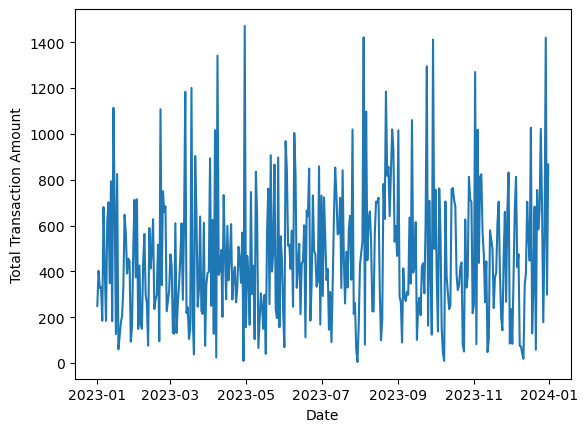

In [3]:
import matplotlib.pyplot as plt

plt.plot(daily_sum['Date'], daily_sum['Total_Transaction'])
plt.xlabel("Date")
plt.ylabel("Total Transaction Amount")
plt.show()

## 2. Long Short-Term Memory (LSTM) mreže

In [4]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def create_windows(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

def predict(model, last_window, n):
    predictions = []
    current_input = last_window.copy()
    for i in range(n):
        input_reshaped = current_input.reshape((1, current_input.shape[0]))
        next_pred = model.predict(input_reshaped, verbose=0)
        predictions.append(next_pred[0, 0])
        current_input = np.append(current_input[1:], next_pred[0,0])

    return predictions

def plot_print(predictions):
    rmse = np.sqrt(mean_squared_error(test["Total_Transaction"], predictions))
    mae = mean_absolute_error(test["Total_Transaction"], predictions)
    print("RMSE:", rmse)
    print("MAE:", mae)
    plt.plot(train.Date, train.Total_Transaction, label="Train")
    plt.plot(test.Date, test.Total_Transaction, label="Test")
    plt.plot(test.Date, predictions, label="Forecast")
    plt.xlabel("Date")
    plt.ylabel("Total Transaction Amount")
    plt.legend()
    plt.show()

In [5]:
from keras.models import Sequential
from keras import Input
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

ws = 15
lr = 1e-2
units = 50

model = Sequential()
model.add(Input(shape=(ws, 1)))
model.add(LSTM(units=units, activation='tanh'))
model.add(Dense(1))
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

X_train, y_train = create_windows(train["Total_Transaction"], ws)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=1000,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0,
)

RMSE: 306.0090934289976
MAE: 240.4552259980648


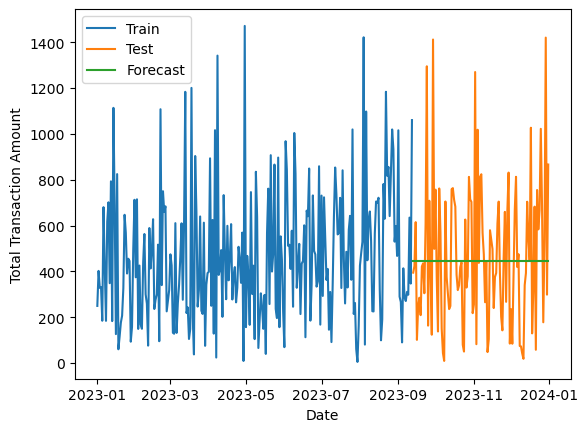

In [6]:
predictions = predict(model, X_train[-1], test.shape[0])
plot_print(predictions)

### Optimizacija hiperparametara

In [7]:
from itertools import product

windows_sizes = [5, 10, 20]
units = [50, 150, 300]
learning_rates = [1e-4, 1e-3, 1e-2]
activations = ['relu', 'tanh', 'sigmoid']

results = []
for ws, unit, lr, activation in product(windows_sizes, units, learning_rates, activations):
    
    model = Sequential()
    model.add(Input(shape=(ws, 1)))
    model.add(LSTM(units=unit, activation=activation))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    X_train, y_train = create_windows(train['Total_Transaction'], ws)

    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=1000,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0,
    )
    
    predictions = predict(model, X_train[-1], test.shape[0])
    rmse = np.sqrt(mean_squared_error(test["Total_Transaction"], predictions))
    mae = mean_absolute_error(test["Total_Transaction"], predictions)

    results.append({
        "ws": ws,
        "units": unit,
        "lr": lr,
        "activation": activation,
        "RMSE": rmse,
        "MAE": mae
    })


results_df = pd.DataFrame(results).sort_values(by="RMSE")
results_df

,ws,units,lr,activation,RMSE,MAE
80,20,300,0.0100,sigmoid,305.479168,241.706341
70,20,150,0.0100,tanh,305.505574,241.616775
71,20,150,0.0100,sigmoid,305.512710,241.593429
61,20,50,0.0100,tanh,305.549292,241.478241
76,20,300,0.0010,tanh,305.551398,241.471823
...,...,...,...,...,...,...
28,10,50,0.0001,tanh,527.157296,430.575628
2,5,50,0.0001,sigmoid,531.642777,435.863676
56,20,50,0.0001,sigmoid,534.909294,439.701595
29,10,50,0.0001,sigmoid,534.984373,439.789639


RMSE: 305.4532900936806
MAE: 241.79834332667363


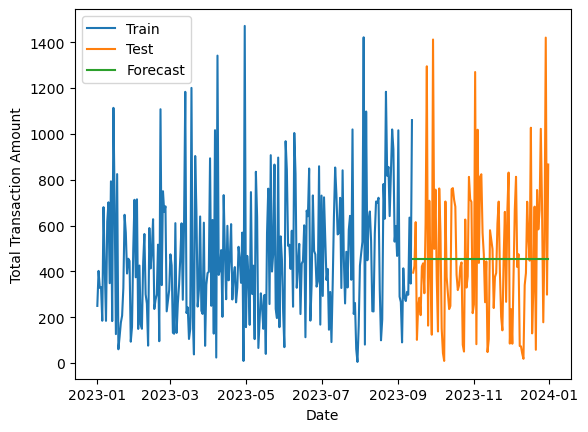

In [8]:
model = Sequential()
model.add(Input(shape=(5, 1)))
model.add(LSTM(units=300, activation='sigmoid'))
model.add(Dense(1))
optimizer = Adam(learning_rate=1e-2)
model.compile(optimizer=optimizer, loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

X_train, y_train = create_windows(train["Total_Transaction"], 20)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=1000,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

predictions = predict(model, X_train[-1], test.shape[0])
plot_print(predictions)

Nakon optimizacije hiperparametara, dobio sam ravnu liniju. Rezultati su usporedivi s modelima iz prošle laboratorijske vježbe kada se nisu optimirali hiperparametri. Rezultati bi vjerojatno bili bolji da je model dublji.

## 3. InceptionTime

In [9]:
from contextlib import contextmanager
import sys
import os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

In [10]:
def predict(model, last_window, n):
    predictions = []
    current_input = last_window.copy()
    for i in range(n):
        input_reshaped = current_input.reshape((1, current_input.shape[0]))
        print(input_reshaped)
        next_pred = model.predict(input_reshaped)
        predictions.append(next_pred[0])
        current_input = np.append(current_input[1:], next_pred[0])

    return predictions

RMSE: 424.0145529238562
MAE: 324.0526179584888


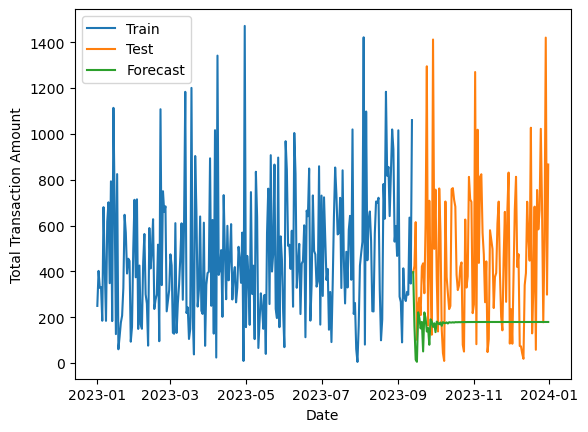

In [11]:
from sktime.regression.deep_learning import InceptionTimeRegressor

ws = 5
X_train, y_train = create_windows(train["Total_Transaction"], ws)

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

model = InceptionTimeRegressor(
    n_epochs=100,
    callbacks=[early_stop],
    verbose=False,
    random_state=42
)
model.fit(X_train, y_train)

with suppress_stdout():
    predictions = predict(model, X_train[-1], test.shape[0])
plot_print(predictions)

### Optimizacija hiperparametara

In [12]:
windows_sizes = [5, 10, 20]
number_of_epochs = [100, 500, 1000]
batch_sizes = [32, 64, 128]
kernel_sizes = [30, 40, 50]

results = []
for ws, epochs, bs, ks in product(windows_sizes, number_of_epochs, batch_sizes, kernel_sizes):
    
    model = InceptionTimeRegressor(
    n_epochs=epochs,
    batch_size=bs,
    kernel_size=ks,
    callbacks=[early_stop],
    verbose=False,
    random_state=42
    )

    X_train, y_train = create_windows(train['Total_Transaction'], ws)

    model.fit(X_train, y_train)
    
    with suppress_stdout():
        predictions = predict(model, X_train[-1], test.shape[0])
    rmse = np.sqrt(mean_squared_error(test["Total_Transaction"], predictions))
    mae = mean_absolute_error(test["Total_Transaction"], predictions)

    results.append({
        "ws": ws,
        "epochs": epochs,
        "bs": bs,
        "ks": ks,
        "RMSE": rmse,
        "MAE": mae
    })


results_df = pd.DataFrame(results).sort_values(by="RMSE")
results_df

,ws,epochs,bs,ks,RMSE,MAE
52,10,1000,128,40,317.088788,247.885755
64,20,500,32,40,321.547823,249.200752
72,20,1000,32,30,322.869084,257.040852
39,10,500,64,30,326.738606,257.776687
57,20,100,64,30,329.321836,247.377127
...,...,...,...,...,...,...
1,5,100,32,40,454.446858,348.047611
6,5,100,128,30,497.378353,397.649684
8,5,100,128,50,544.767841,451.271601
3,5,100,64,30,547.526561,453.585161


RMSE: 342.3791827631241
MAE: 255.6721865340767


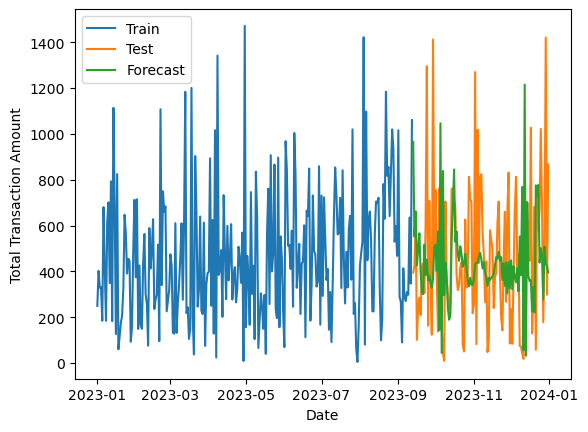

In [13]:
model = InceptionTimeRegressor(
    n_epochs=1000,
    batch_size=128,
    kernel_size=40,
    callbacks=[early_stop],
    verbose=False,
    random_state=42
    )

X_train, y_train = create_windows(train["Total_Transaction"], 10)

model.fit(X_train, y_train)
    
with suppress_stdout():
    predictions = predict(model, X_train[-1], test.shape[0])

plot_print(predictions)

Nakon optimizacije hiperparametara predikcije izgledaju "prirodno", no greška je još uvijek velika.